In [1]:
import os
import dask.array as da
import networkx as nx
import numpy as np
import zarr
from epynet import Network

import sys
sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph
from DataReader import DataReader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wds_id = 'ctown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

# Loading data
### Loading graph

In [4]:
wds = Network(path_to_wds)
G_unweighted = get_nx_graph(wds, mode='binary')
L_unweighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_unweighted).todense())
L_unweighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_unweighted).todense())
G_weighted = get_nx_graph(wds, mode='weighted')
L_weighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_weighted).todense())
L_weighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_weighted).todense())

### Loading signal

In [5]:
reader = DataReader(path_to_data, n_junc=len(wds.junctions.uid), obsrat=.1, seed=None)
X_complete, _, _ = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = None,
    cover = False
)
X_sparse, _, _ = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = None,
    cover = True
)

# Graph signal processing
### Smoothness

In [6]:
X = X_complete[:,:,0].T
smoothness_unweighted = da.dot(X.T, da.dot(L_unweighted, X)).trace()
smoothness_weighted = da.dot(X.T, da.dot(L_weighted, X)).trace()

In [7]:
print('Smoothness with unweighted Laplacian: {:.0f}.'.format(smoothness_unweighted.compute()))
print('Smoothness with weighted Laplacian: {:.0f}.'.format(smoothness_weighted.compute()))

Smoothness with unweighted Laplacian: 1595729449.
Smoothness with weighted Laplacian: 142548625.


### Spectrum

In [8]:
eigvals_weighted = np.linalg.eigvals(L_weighted_normalized.compute()).real
eigvals_unweighted = np.linalg.eigvals(L_unweighted_normalized.compute()).real

<BarContainer object of 388 artists>

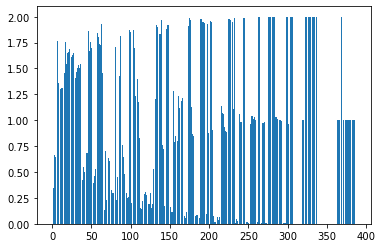

In [9]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_weighted)

<BarContainer object of 388 artists>

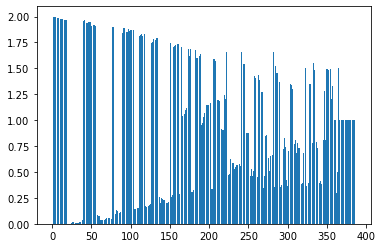

In [10]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_unweighted)

# Signal reconstruction
### Getting S: rearranging the Laplacian

In [11]:
S = np.array(L_unweighted)
F = X_sparse[:,:,0].copy()
X_reconstructed = X_sparse[:,:,0].copy()
flag_observed = X_sparse[:,:,1][0,:]

In [12]:
insert_idx = 0
for i, flag in enumerate(flag_observed):
    if flag:
        observed_col = np.copy(S[:,i])
        S[:,i] = S[:,insert_idx]
        S[:,insert_idx] = observed_col
        
        S[i,:] = S[insert_idx,:]
        S[insert_idx,:] = observed_col.T
        
        observed_col = np.copy(F[:,i])
        F[:,i] = F[:,insert_idx]
        F[:,insert_idx] = observed_col
        
        insert_idx += 1

In [13]:
F = F[:,:insert_idx]
S_2 = S[:insert_idx, insert_idx:]
S_3 = S[insert_idx:, insert_idx:]
try:
    S_3_inv = np.linalg.inv(S_3)
except:
    S_3_inv = np.linalg.pinv(S_3)

In [14]:
F_hat = -np.dot(S_3_inv, np.dot(S_2.T, F.T)).T

In [15]:
insert_idx = 0
for i, flag in enumerate(flag_observed):
    if not flag:
        X_reconstructed[:,i] = F_hat[:,insert_idx]
        insert_idx += 1

In [16]:
diff = X_reconstructed-X.T

In [17]:
np.mean(np.abs(diff))

314.0723018046934